We will use OpenAI's [gym](https://github.com/openai/gym) package which includes the Cartpole environment amongst many others (e.g. Atari games and MuJoCo simulation engine). Let's import the module, set up the environment and check the observation and action space:

In [1]:
import gym
env = gym.make('CartPole-v0')

In [2]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [3]:
env.action_space

Discrete(2)

In [4]:
import numpy as np

class LogisticPolicy:
    
    def __init__(self, θ, α, γ):
        # Initialize paramters θ, learning rate α and discount factor γ
        
        self.θ = θ
        self.α = α
        self.γ = γ
        
    def logistic(self, y):
        # definition of logistic function
        
        return 1/(1 + np.exp(-y))
    
    def probs(self, x):
        # returns probabilities of two actions
        
        y = x @ self.θ
        prob0 = self.logistic(y)
        
        return np.array([prob0, 1-prob0])        
    
    def act(self, x):
        # sample an action in proportion to probabilities
        
        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)
        
        return action, probs[action]
    
    def grad_log_p(self, x):
        # calculate grad-log-probs
        
        y = x @ self.θ        
        grad_log_p0 = x - x*self.logistic(y)
        grad_log_p1 = - x*self.logistic(y)
        
        return grad_log_p0, grad_log_p1
        
    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # dot grads with future rewards for each action in episode
        
        return grad_log_p.T @ discounted_rewards
    
    def discount_rewards(self, rewards):
        # calculate temporally adjusted, discounted rewards
        
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
            discounted_rewards[i] = cumulative_rewards
            
        return discounted_rewards

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grad_log_p = np.array([self.grad_log_p(ob)[action] for ob,action in zip(obs,actions)])
        
        assert grad_log_p.shape == (len(obs), 4)
        
        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)
        
        # gradients times rewards
        dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)
        
        # gradient ascent on parameters
        self.θ += self.α*dot

Let's also write a utility function that will run through one full episode and record all observations, actions taken and rewards received.

In [5]:
def run_episode(env, policy, render=False):
    
    observation = env.reset()
    totalreward = 0
    
    observations = []
    actions = []
    rewards = []
    probs = []
    
    done = False
    
    while not done:
        if render:
            env.render()
        
        observations.append(observation)
        
        action, prob = policy.act(observation)
        observation, reward, done, info = env.step(action)
        
        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)
    
    return totalreward, np.array(rewards), np.array(observations), np.array(actions), np.array(probs)

Finally, we write a training loop that will train an agent on the problem by repeated rollouts of a policy that is updated after the end of every episode:

In [6]:
def train(θ, α, γ, Policy, MAX_EPISODES=1000, seed=None, evaluate=False):
    
    # initialize environment and policy
    env = gym.make('CartPole-v0')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)
    
    # train until MAX_EPISODES
    for i in range(MAX_EPISODES):

        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, policy)
                
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        
        # update policy
        policy.update(rewards, observations, actions)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False) 

    # evaluation call after training is finished - evaluate last trained policy on 100 episodes
    if evaluate:
        env = Monitor(env, 'pg_cartpole/', video_callable=False, force=True)
        for _ in range(100):
            run_episode(env, policy, render=False)
        env.env.close()
        
    return episode_rewards, policy

Let's run it:

In [7]:
# additional imports for saving and loading a trained policy
from gym.wrappers.monitor import Monitor, load_results

# for reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

episode_rewards, policy = train(θ=np.random.rand(4),
                                α=0.002,
                                γ=0.99,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=2000,
                                seed=GLOBAL_SEED,
                                evaluate=True)

Let's inspect the results by plotting the reward against episode number during training:

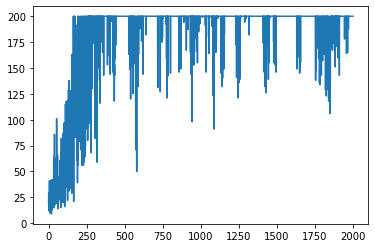

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(episode_rewards);

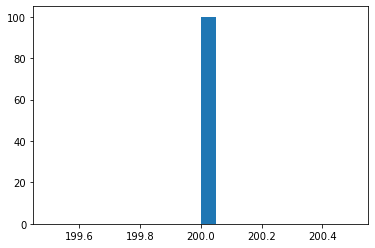

In [9]:
results = load_results('pg_cartpole')
plt.hist(results['episode_rewards'], bins=20);

This is saying that the last trained policy was able to successfully control the cart and keep the pole upright for 200 steps in all 100 evaluation episodes!